# Mood Classification with 4 Classes and Temporal Models

This notebook implements classification algorithms to predict the mood of the next day for subjects in the dataset, using 4 mood classes and including a temporal algorithm (Hidden Markov Model).

## Contents
1. Imports and Setup
2. Data Loading and Preparation
3. Exploratory Data Analysis
4. Feature Engineering (4-Class Classification)
5. Model Training and Evaluation
6. Temporal Model (Hidden Markov Model)
7. Model Comparison and Results

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from IPython.display import display

# For data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# For model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Temporal algorithms
from hmmlearn import hmm
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier

# For sequence preparation
from collections import defaultdict

# Import our custom cleaning module
import cleaning

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Create plots directory if it doesn't exist
if not os.path.exists("./plots"):
    os.makedirs("./plots")

In [14]:
def load_and_prepare_data(file_path="./Data/dataset_mood_smartphone.csv"):
    """
    Load and prepare the data for analysis and modeling.
    """
    print("Loading and preparing data...")
    
    # Load the data using our existing cleaning module
    raw_data, users = cleaning.loadData(file_path)
    
    # Resample to daily data
    daily_data = cleaning.resample_daily(raw_data, users)
    
    # Prune to keep only the longest continuous period with mood data
    pruned_daily = cleaning.pruneDays(daily_data, users, method="longest", baseFrame=raw_data)
    
    print(f"Data loaded successfully. Found {len(users)} users.")
    
    return pruned_daily, users

# Load the data
data, users = load_and_prepare_data()

Loading and preparing data...
Data loaded successfully. Found 27 users.



--- Exploratory Data Analysis ---

Summary Statistics:


variable,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,screen,sms,call,activity,circumplex.arousal,circumplex.valence,mood
count,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1091.000000,1093.000000
mean,1266.444729,2562.786359,865.757340,18.526379,84.063745,73.798800,160.903924,1035.656766,112.081573,31.427018,39.093540,3.614087,5676.249532,0.855444,2.253431,0.108841,-0.121051,0.692751,6.973643
std,3905.649916,2530.452205,1771.776292,77.807550,508.033619,1021.391544,385.151874,1793.963594,474.722960,146.314704,155.102177,18.141762,4744.761639,1.853410,3.232844,0.095020,0.662378,0.434853,0.750809
min,-80367.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-1.250000,3.000000
25%,162.032000,649.433000,0.000000,0.000000,0.000000,0.000000,38.161000,17.041000,0.000000,0.000000,0.000000,0.000000,1930.908000,0.000000,0.000000,0.041876,-0.600000,0.400000,6.600000
50%,635.303000,1882.340000,217.571000,0.000000,0.000000,0.000000,61.305000,396.672000,0.000000,0.000000,0.000000,0.000000,4765.971998,0.000000,1.000000,0.090177,0.000000,0.800000,7.000000
75%,1442.645000,3706.306000,1091.925000,0.000000,0.000000,0.000000,125.669000,1495.451000,64.902000,0.000000,10.033000,0.000000,8186.036001,1.000000,3.000000,0.143134,0.333333,1.000000,7.500000
max,40323.877000,20718.749000,35937.645000,1321.104000,12996.495000,33283.021000,4335.307000,30073.421000,10548.116000,2821.547000,2257.626000,366.937000,36204.105001,15.000000,25.000000,0.543843,2.000000,2.000000,9.333333



Missing Values:


variable
appCat.builtin          0
appCat.communication    0
appCat.entertainment    0
appCat.finance          0
appCat.game             0
appCat.office           0
appCat.other            0
appCat.social           0
appCat.travel           0
appCat.unknown          0
appCat.utilities        0
appCat.weather          0
screen                  0
sms                     0
call                    0
activity                0
circumplex.arousal      0
circumplex.valence      2
mood                    0
dtype: int64

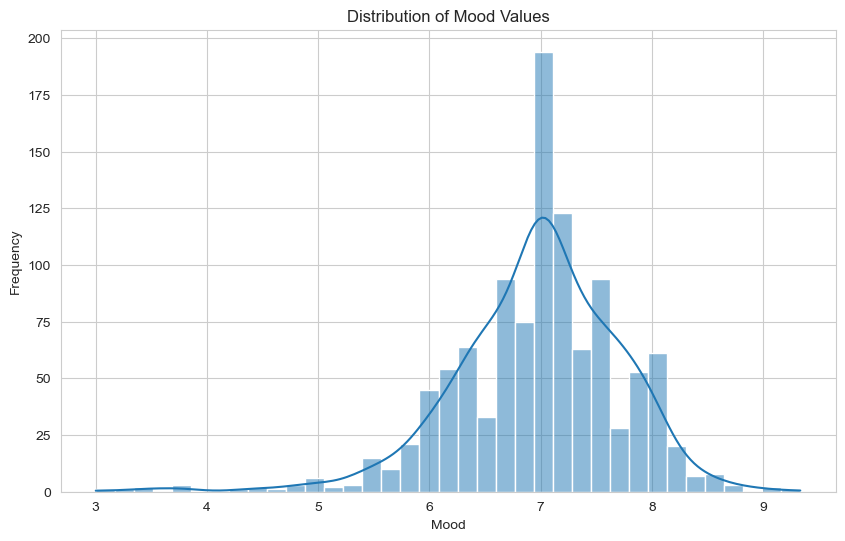

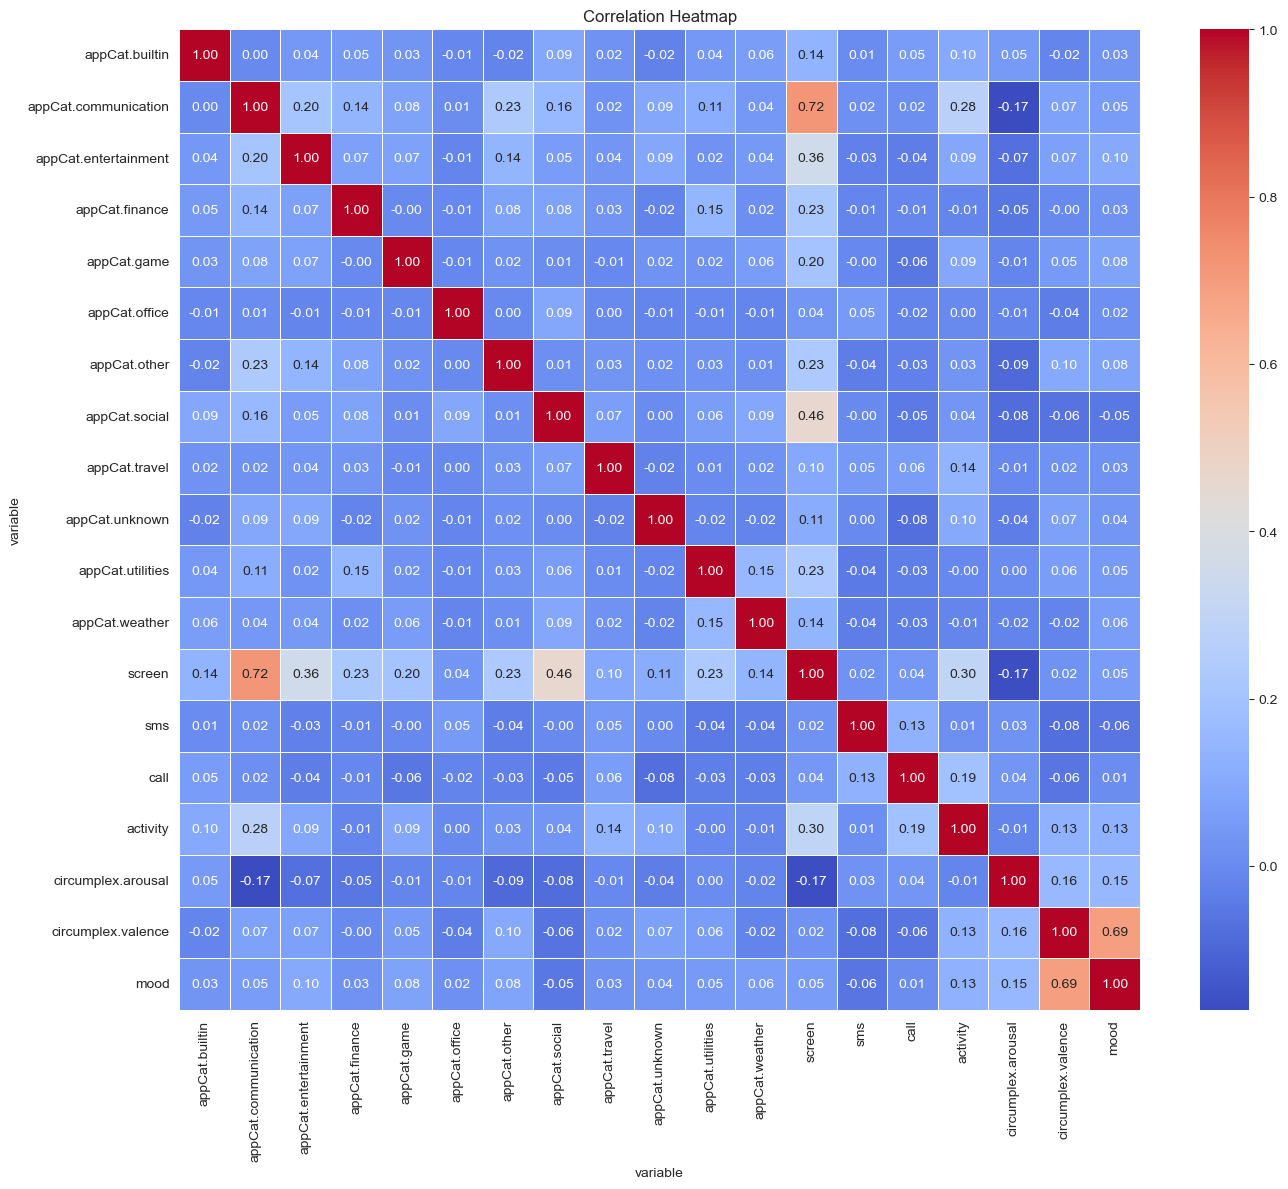

EDA completed.


In [15]:
def perform_eda(data):
    """
    Perform Exploratory Data Analysis on the dataset.
    """
    print("\n--- Exploratory Data Analysis ---")
    
    # 1. Summary statistics
    print("\nSummary Statistics:")
    summary_stats = data.describe()
    display(summary_stats)
    
    # 2. Check for missing values
    print("\nMissing Values:")
    missing_values = data.isna().sum()
    display(missing_values)
    
    # 3. Distribution of mood values
    plt.figure(figsize=(10, 6))
    sns.histplot(data["mood"].dropna(), kde=True)
    plt.title("Distribution of Mood Values")
    plt.xlabel("Mood")
    plt.ylabel("Frequency")
    plt.savefig("./plots/mood_distribution.png")
    plt.show()
    
    # 4. Correlation heatmap of numeric columns
    plt.figure(figsize=(14, 12))
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    corr_matrix = data[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.savefig("./plots/correlation_heatmap.png")
    plt.show()
    
    print("EDA completed.")
    
    return summary_stats, missing_values

# Perform EDA
summary_stats, missing_values = perform_eda(data)

# sliding window

Only use a certain amount of days to make the prediction

In [16]:
def create_sliding_window_features(data, users, window_size=3):
    """
    Create features using a sliding window of past days to predict the next day's mood.
    
    Args:
        data: The dataset (multi-index DataFrame with user and time)
        users: List of user IDs
        window_size: Number of past days to use for prediction (default: 3)
        
    Returns:
        X: Feature matrix where each row contains features from window_size days
        y: Target vector (next day's mood class)
        user_ids: Array of user IDs corresponding to each sample
        timestamps: Array of timestamps for the target day
    """
    print(f"\n--- Creating {window_size}-Day Sliding Window Features ---")
    
    # Create a copy of the data
    processed_data = data.copy()
    
    # Fill missing values with median for each user
    for user in users:
        for col in processed_data.columns:
            if processed_data.loc[user][col].isna().any():
                user_median = processed_data.loc[user][col].median()
                if pd.isna(user_median):
                    user_median = 0
                processed_data.loc[user, col] = processed_data.loc[user][col].fillna(user_median)
    
    # Create features and target dataframes
    X_data = []
    y_data = []
    user_ids = []
    timestamps = []
    
    # Get feature names (excluding 'mood')
    feature_names = [col for col in processed_data.columns if col != 'mood']
    num_features = len(feature_names)
    
    for user in users:
        user_data = processed_data.loc[user]
        
        # Skip users with insufficient data
        if len(user_data) < window_size + 1:
            continue
            
        # For each possible window in the user's data
        for i in range(len(user_data) - window_size):
            # Get window of past days
            window_data = user_data.iloc[i:i+window_size]
            
            # Create a flat feature vector containing all features from all days in the window
            window_features = []
            for day in range(window_size):
                # Extract features for this day (excluding mood)
                day_features = window_data.iloc[day][feature_names].values
                window_features.extend(day_features)
            
            # Next day's mood (target)
            next_day_mood = user_data.iloc[i+window_size]['mood']
            next_day_timestamp = user_data.index[i+window_size]
            
            # Convert to 4 classes based on quartiles
            user_mood_quartiles = user_data['mood'].quantile([0.25, 0.5, 0.75]).values
            
            if next_day_mood < user_mood_quartiles[0]:
                mood_class = 0  # Very low mood
            elif next_day_mood < user_mood_quartiles[1]:
                mood_class = 1  # Low mood
            elif next_day_mood < user_mood_quartiles[2]:
                mood_class = 2  # Good mood
            else:
                mood_class = 3  # Very good mood
            
            # Only add if there are no NaN values in the features
            if not np.isnan(window_features).any():
                X_data.append(window_features)
                y_data.append(mood_class)
                user_ids.append(user)
                timestamps.append(next_day_timestamp)
    
    # Convert to numpy arrays
    X = np.array(X_data)
    y = np.array(y_data)
    user_ids = np.array(user_ids)
    timestamps = np.array(timestamps)
    
    # Create expanded feature names to include day information
    expanded_feature_names = []
    for day in range(window_size):
        day_features = [f"day-{window_size-day}_{feat}" for feat in feature_names]
        expanded_feature_names.extend(day_features)
    
    print(f"Sliding window features created. X shape: {X.shape}, y shape: {y.shape}")
    print(f"Each sample contains {window_size} days of data ({num_features} features per day)")
    print(f"Class distribution: {np.bincount(y)}")
    
    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y)
    plt.title(f'Distribution of Mood Classes ({window_size}-Day Window)')
    plt.xlabel('Mood Class')
    plt.xticks([0, 1, 2, 3], ['Very Low', 'Low', 'Good', 'Very Good'])
    plt.ylabel('Count')
    plt.savefig(f"./plots/class_distribution_{window_size}day_window.png")
    plt.show()
    
    return X, y, expanded_feature_names, user_ids, timestamps


--- Creating 3-Day Sliding Window Features ---
Sliding window features created. X shape: (982, 54), y shape: (982,)
Each sample contains 3 days of data (18 features per day)
Class distribution: [212 205 264 301]


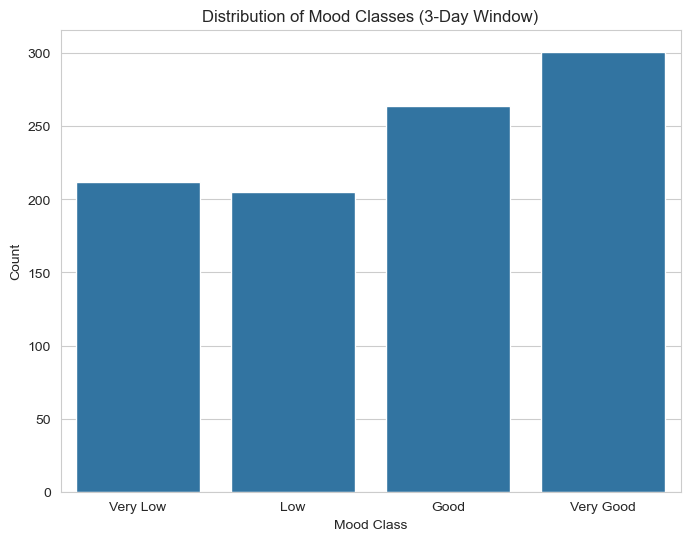


Comparison:
Single-day approach: 54 features per sample
3-day window approach: 54 features per sample


In [17]:
# Create features using a 3-day sliding window
window_size = 3
X_window, y_window, feature_names_window, user_ids_window, timestamps_window = create_sliding_window_features(
    data, users, window_size=window_size
)

# Compare with single-day features
print("\nComparison:")
print(f"Single-day approach: {len(feature_names_window)} features per sample")
print(f"{window_size}-day window approach: {len(feature_names_window)} features per sample")

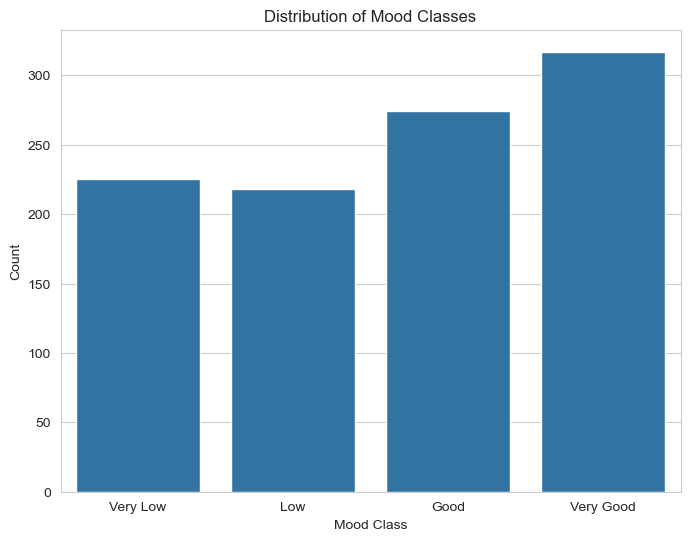

In [18]:
def prepare_features_and_target(data, users):
    # Create a copy of the data
    processed_data = data.copy()
    
    # Fill missing values with median for each user
    for user in users:
        for col in processed_data.columns:
            if processed_data.loc[user][col].isna().any():
                user_median = processed_data.loc[user][col].median()
                if pd.isna(user_median):
                    user_median = 0
                processed_data.loc[user, col] = processed_data.loc[user][col].fillna(user_median)
    
    # Create features and target dataframes
    X_data = []
    y_data = []
    user_ids = []  # Store user IDs for temporal models
    timestamps = []  # Store timestamps for temporal models
    
    for user in users:
        user_data = processed_data.loc[user]
        
        # Skip users with less than 2 days of data
        if len(user_data) < 2:
            continue
            
        # For each day, use current day's data to predict next day's mood
        for i in range(len(user_data) - 1):
            # Current day's features
            features = user_data.iloc[i].drop('mood').values
            
            # Next day's mood (target)
            next_day_mood = user_data.iloc[i+1]['mood']
            
            # Convert to 4 classes based on quartiles
            # Class 0: Very low mood (0-25th percentile)
            # Class 1: Low mood (25-50th percentile)
            # Class 2: Good mood (50-75th percentile)
            # Class 3: Very good mood (75-100th percentile)
            user_mood_quartiles = user_data['mood'].quantile([0.25, 0.5, 0.75]).values
            
            if next_day_mood < user_mood_quartiles[0]:
                mood_class = 0  # Very low mood
            elif next_day_mood < user_mood_quartiles[1]:
                mood_class = 1  # Low mood
            elif next_day_mood < user_mood_quartiles[2]:
                mood_class = 2  # Good mood
            else:
                mood_class = 3  # Very good mood
            
            # Only add if there are no NaN values in the features
            if not np.isnan(features).any():
                X_data.append(features)
                y_data.append(mood_class)
                user_ids.append(user)
                timestamps.append(user_data.index[i+1])  # Next day's timestamp
    
    # Convert to numpy arrays
    X = np.array(X_data)
    y = np.array(y_data)
    user_ids = np.array(user_ids)
    timestamps = np.array(timestamps)
    
    # Get feature names (excluding 'mood')
    feature_names = [col for col in processed_data.columns if col != 'mood']
    
    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y)
    plt.title('Distribution of Mood Classes')
    plt.xlabel('Mood Class')
    plt.xticks([0, 1, 2, 3], ['Very Low', 'Low', 'Good', 'Very Good'])
    plt.ylabel('Count')
    plt.savefig("./plots/class_distribution.png")
    plt.show()
    
    return X, y, feature_names, user_ids, timestamps

# Prepare features and target
X, y, feature_names, user_ids, timestamps = prepare_features_and_target(data, users)

In [19]:
def train_and_evaluate_models(X, y, feature_names, user_ids=None, timestamps=None):
    # Check for any remaining NaN values
    if np.isnan(X).any():
        print("WARNING: NaN values detected in features. Removing rows with NaN values.")
        # Find rows without NaN values
        mask = ~np.isnan(X).any(axis=1)
        X = X[mask]
        y = y[mask]
        if user_ids is not None:
            user_ids = user_ids[mask]
        if timestamps is not None:
            timestamps = timestamps[mask]
        print(f"After removing NaN values: X shape: {X.shape}, y shape: {y.shape}")
    
    # Split data into training and testing sets (80% train, 20% test)
    if user_ids is not None and timestamps is not None:
        # Use time-based split for temporal data
        # Sort by timestamp
        sorted_indices = np.argsort(timestamps)
        X = X[sorted_indices]
        y = y[sorted_indices]
        user_ids = user_ids[sorted_indices]
        timestamps = timestamps[sorted_indices]
        
        # Use the last 20% as test set
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        user_ids_train, user_ids_test = user_ids[:split_idx], user_ids[split_idx:]
        timestamps_train, timestamps_test = timestamps[:split_idx], timestamps[split_idx:]
    else:
        # Regular stratified split for non-temporal models
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models to evaluate
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', max_iter=1000)
    }
    
    # Dictionary to store results
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        try:
            # Train the model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            # Use macro averaging for multi-class classification
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
            
            # Print results
            print(f"{name} Results:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            
            # Print classification report
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, zero_division=0))
            
            # Print confusion matrix
            print("\nConfusion Matrix:")
            cm = confusion_matrix(y_test, y_pred)
            print(cm)
            
            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Very Low', 'Low', 'Good', 'Very Good'],
                        yticklabels=['Very Low', 'Low', 'Good', 'Very Good'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix - {name}')
            plt.tight_layout()
            plt.savefig(f"./plots/confusion_matrix_{name.replace(' ', '_').lower()}.png")
            plt.show()
            
            # Store results
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'confusion_matrix': cm,
                'y_pred': y_pred
            }
            
            # Feature importance for tree-based models
            if name in ['Decision Tree', 'Random Forest']:
                importances = model.feature_importances_
                indices = np.argsort(importances)[::-1]
                
                # Plot feature importance
                plt.figure(figsize=(12, 8))
                plt.title(f'Feature Importance - {name}')
                plt.bar(range(min(10, X.shape[1])), importances[indices[:10]], align='center')
                plt.xticks(range(min(10, X.shape[1])), [feature_names[i] for i in indices[:10]], rotation=90)
                plt.tight_layout()
                plt.savefig(f"./plots/feature_importance_{name.replace(' ', '_').lower()}.png")
                plt.show()
                
                # Print top 10 features
                print("\nTop 10 Features:")
                for i in range(min(10, X.shape[1])):
                    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
        
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            print(f"Skipping {name} model.")
    
    return results, X_train_scaled, y_train, X_test_scaled, y_test, user_ids_train, user_ids_test


Training Decision Tree...
Decision Tree Results:
Accuracy: 0.2843
Precision: 0.2772
Recall: 0.2808
F1 Score: 0.2782

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.34      0.32        41
           1       0.20      0.22      0.21        41
           2       0.24      0.21      0.22        53
           3       0.37      0.35      0.36        62

    accuracy                           0.28       197
   macro avg       0.28      0.28      0.28       197
weighted avg       0.28      0.28      0.28       197


Confusion Matrix:
[[14  6 11 10]
 [ 9  9 11 12]
 [14 12 11 16]
 [10 18 12 22]]


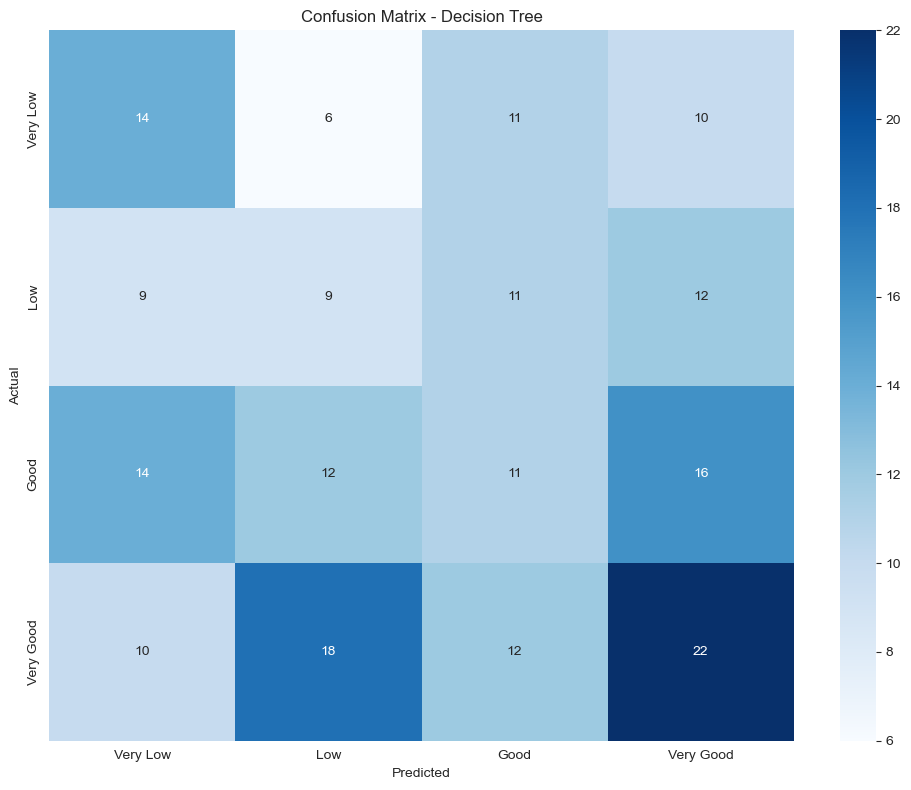

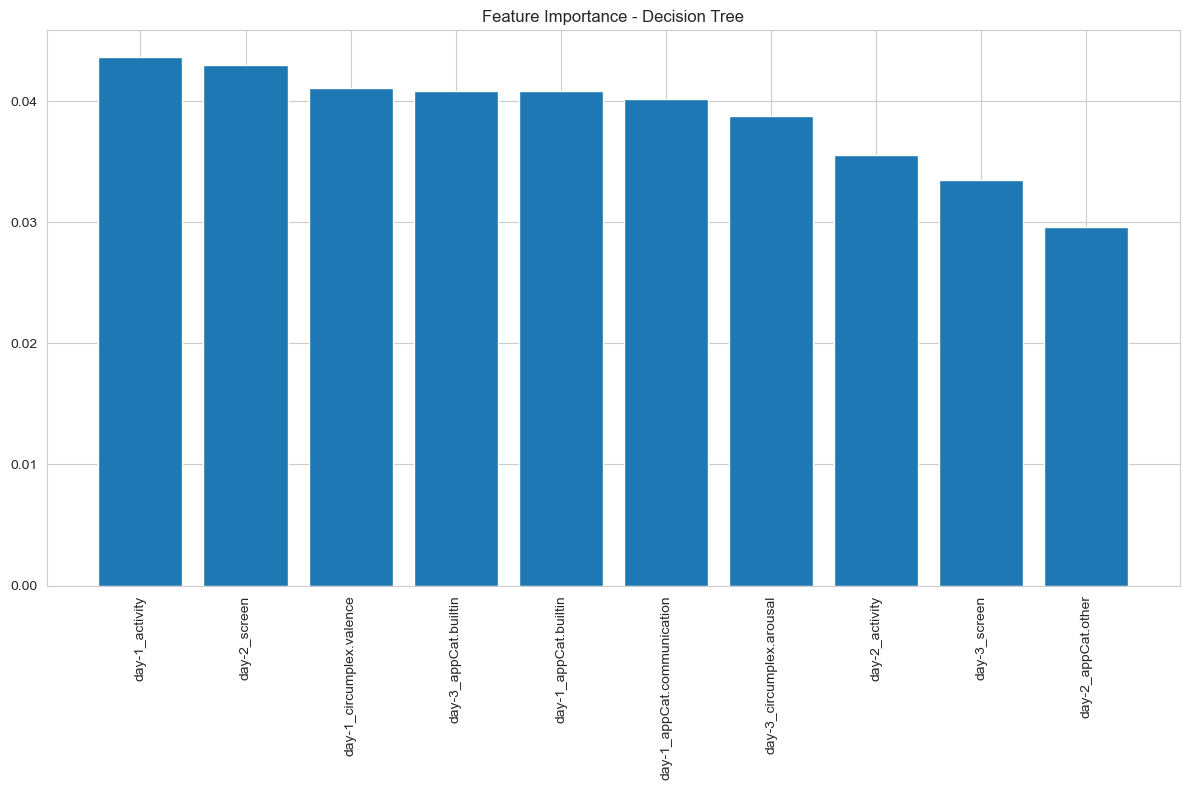


Top 10 Features:
day-1_activity: 0.0436
day-2_screen: 0.0430
day-1_circumplex.valence: 0.0411
day-3_appCat.builtin: 0.0408
day-1_appCat.builtin: 0.0408
day-1_appCat.communication: 0.0402
day-3_circumplex.arousal: 0.0387
day-2_activity: 0.0355
day-3_screen: 0.0335
day-2_appCat.other: 0.0296

Training Random Forest...
Random Forest Results:
Accuracy: 0.3249
Precision: 0.2812
Recall: 0.2993
F1 Score: 0.2833

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.32      0.33        41
           1       0.11      0.05      0.07        41
           2       0.31      0.28      0.30        53
           3       0.37      0.55      0.44        62

    accuracy                           0.32       197
   macro avg       0.28      0.30      0.28       197
weighted avg       0.29      0.32      0.30       197


Confusion Matrix:
[[13  4  7 17]
 [ 8  2  9 22]
 [12  8 15 18]
 [ 6  5 17 34]]


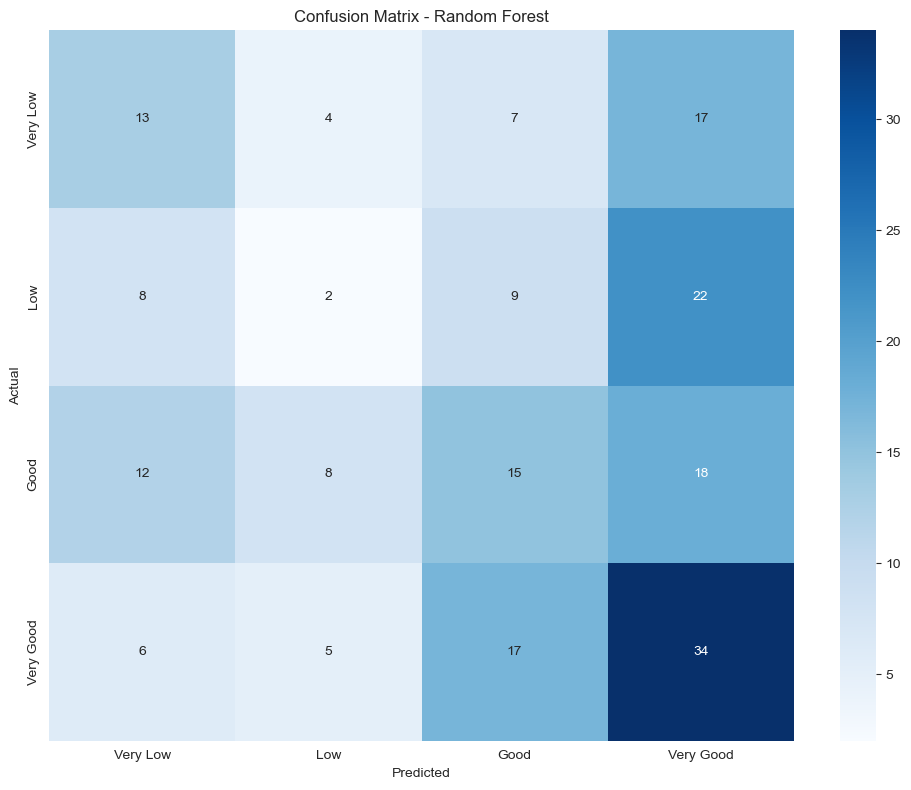

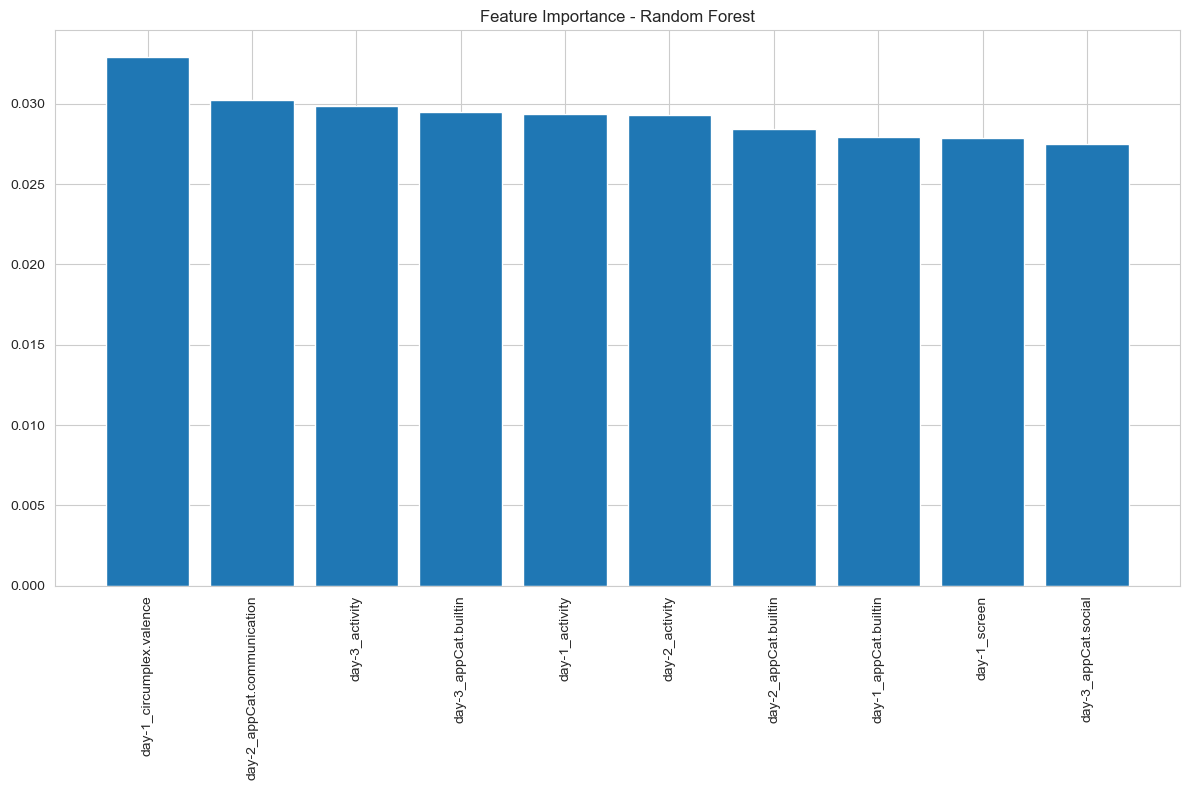


Top 10 Features:
day-1_circumplex.valence: 0.0329
day-2_appCat.communication: 0.0302
day-3_activity: 0.0299
day-3_appCat.builtin: 0.0295
day-1_activity: 0.0294
day-2_activity: 0.0293
day-2_appCat.builtin: 0.0284
day-1_appCat.builtin: 0.0279
day-1_screen: 0.0279
day-3_appCat.social: 0.0275

Training SVM...
SVM Results:
Accuracy: 0.3046
Precision: 0.2743
Recall: 0.2667
F1 Score: 0.2366

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.15      0.20        41
           1       0.17      0.02      0.04        41
           2       0.28      0.28      0.28        53
           3       0.32      0.61      0.42        62

    accuracy                           0.30       197
   macro avg       0.27      0.27      0.24       197
weighted avg       0.28      0.30      0.26       197


Confusion Matrix:
[[ 6  2  9 24]
 [ 4  1  9 27]
 [ 6  2 15 30]
 [ 2  1 21 38]]


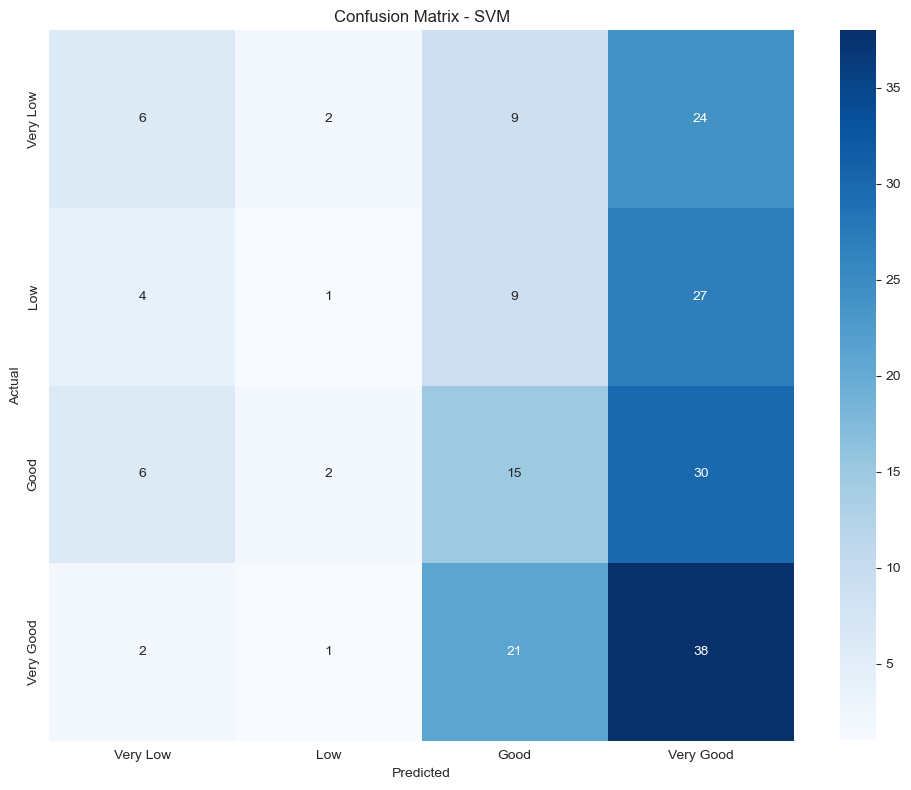


Training KNN...
KNN Results:
Accuracy: 0.2437
Precision: 0.2340
Recall: 0.2383
F1 Score: 0.2344

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.34      0.31        41
           1       0.10      0.10      0.10        41
           2       0.27      0.21      0.23        53
           3       0.28      0.31      0.29        62

    accuracy                           0.24       197
   macro avg       0.23      0.24      0.23       197
weighted avg       0.24      0.24      0.24       197


Confusion Matrix:
[[14  9  6 12]
 [10  4  9 18]
 [ 9 14 11 19]
 [16 12 15 19]]


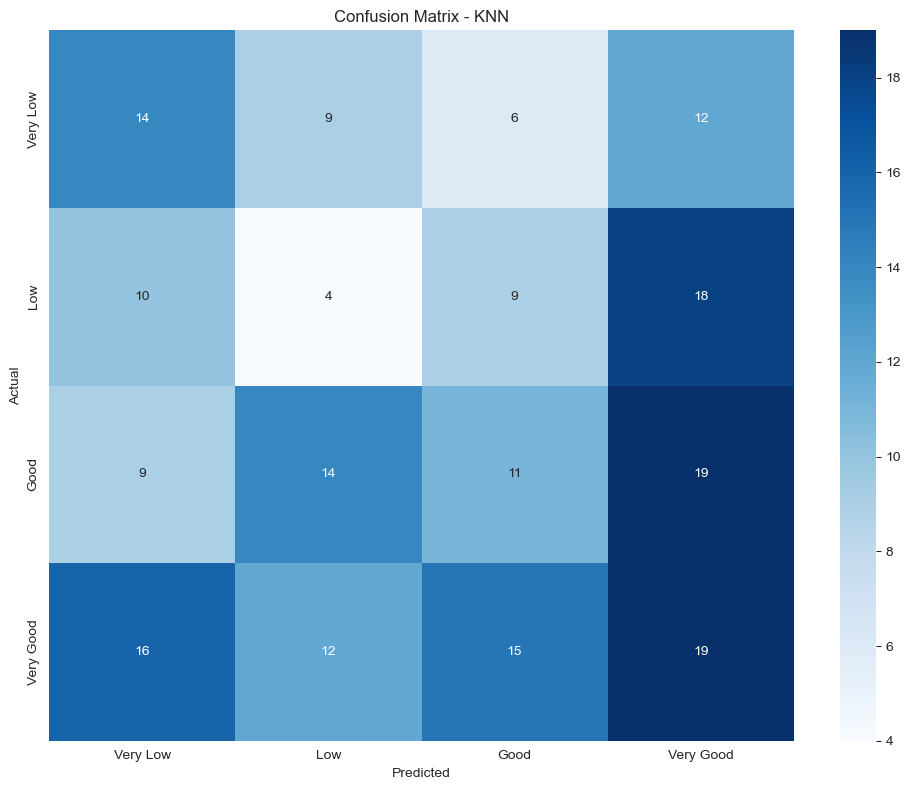


Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.2995
Precision: 0.2915
Recall: 0.2860
F1 Score: 0.2806

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.34      0.34        41
           1       0.26      0.12      0.17        41
           2       0.24      0.25      0.24        53
           3       0.33      0.44      0.38        62

    accuracy                           0.30       197
   macro avg       0.29      0.29      0.28       197
weighted avg       0.29      0.30      0.29       197


Confusion Matrix:
[[14  4  9 14]
 [ 6  5 12 18]
 [13  5 13 22]
 [ 9  5 21 27]]


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


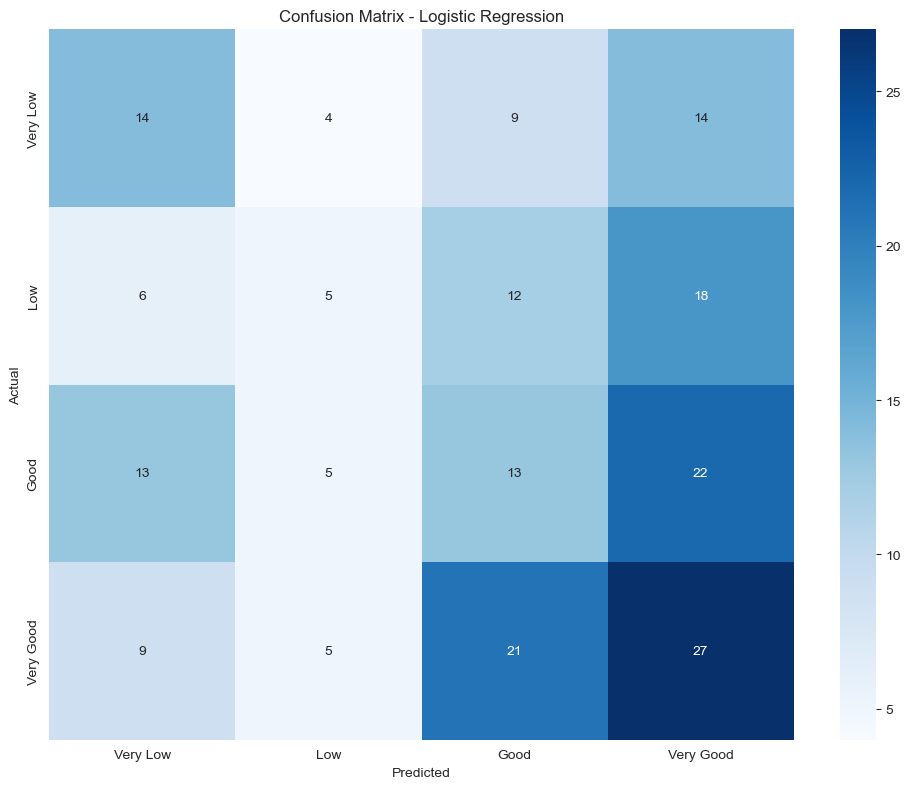

In [25]:
# Train and evaluate models
results, X_train_window_scaled, y_train_window, X_test_window_scaled, y_test_window, user_ids_train_window, user_ids_test_window = train_and_evaluate_models(
    X_window, y_window, feature_names_window, user_ids_window, timestamps_window
)

In [21]:
def train_hmm(X_train, y_train, X_test, y_test, user_ids_train, user_ids_test):
    """
    Train a Hidden Markov Model for temporal mood prediction.
    """
    print("\nTraining Hidden Markov Model (HMM)...")
    
    # Group data by user to create sequences
    user_sequences = defaultdict(list)
    user_labels = defaultdict(list)
    
    # Create sequences for each user
    for i in range(len(X_train)):
        user = user_ids_train[i]
        user_sequences[user].append(X_train[i])
        user_labels[user].append(y_train[i])
    
    # Initialize HMM with 4 hidden states (one for each mood class)
    model = hmm.GaussianHMM(n_components=4, covariance_type="diag", n_iter=100, random_state=42)
    
    # Prepare data for HMM training
    X_hmm = []
    lengths = []
    
    for user, sequence in user_sequences.items():
        if len(sequence) > 1:  # Need at least 2 observations for HMM
            X_hmm.extend(sequence)
            lengths.append(len(sequence))
    
    # Convert to numpy array
    X_hmm = np.vstack(X_hmm)
    
    # Train HMM
    model.fit(X_hmm, lengths=lengths)
    
    # Predict on test set
    # Group test data by user
    test_user_sequences = defaultdict(list)
    test_user_indices = defaultdict(list)
    
    for i in range(len(X_test)):
        user = user_ids_test[i]
        test_user_sequences[user].append(X_test[i])
        test_user_indices[user].append(i)
    
    # Make predictions
    y_pred = np.zeros(len(y_test))
    
    for user, sequence in test_user_sequences.items():
        if len(sequence) > 0:
            # Convert to numpy array
            seq_array = np.vstack(sequence)
            
            # Predict hidden states
            hidden_states = model.predict(seq_array)
            
            # Map hidden states to mood classes (using majority vote from training)
            state_to_mood = {}
            for state in range(4):
                # Find the most common mood class for each hidden state in training
                state_indices = (model.predict(X_hmm) == state)
                if np.any(state_indices):
                    # Get corresponding training labels
                    state_labels = []
                    idx = 0
                    for length in lengths:
                        for j in range(length):
                            if state_indices[idx + j]:
                                user_id = list(user_sequences.keys())[sum(i < idx + j for i in np.cumsum(lengths)) - 1]
                                label_idx = j
                                if label_idx < len(user_labels[user_id]):
                                    state_labels.append(user_labels[user_id][label_idx])
                        idx += length
                    
                    if state_labels:
                        # Assign the most common mood class to this state
                        state_to_mood[state] = max(set(state_labels), key=state_labels.count)
                    else:
                        # If no examples, assign a default class
                        state_to_mood[state] = 0
                else:
                    # If state never occurs in training, assign a default class
                    state_to_mood[state] = 0
            
            # Map hidden states to mood classes
            for i, state in enumerate(hidden_states):
                idx = test_user_indices[user][i]
                y_pred[idx] = state_to_mood.get(state, 0)  # Default to class 0 if state not in mapping
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Print results
    print("HMM Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Very Low', 'Low', 'Good', 'Very Good'],
                yticklabels=['Very Low', 'Low', 'Good', 'Very Good'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - HMM')
    plt.tight_layout()
    plt.savefig("./plots/confusion_matrix_hmm.png")
    plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }


Training Hidden Markov Model (HMM)...
HMM Results:
Accuracy: 0.2944
Precision: 0.1270
Recall: 0.2373
F1 Score: 0.1453

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00        41
           2       0.20      0.09      0.13        53
           3       0.31      0.85      0.45        62

    accuracy                           0.29       197
   macro avg       0.13      0.24      0.15       197
weighted avg       0.15      0.29      0.18       197


Confusion Matrix:
[[ 0  0  6 35]
 [ 0  0  5 36]
 [ 0  0  5 48]
 [ 0  0  9 53]]


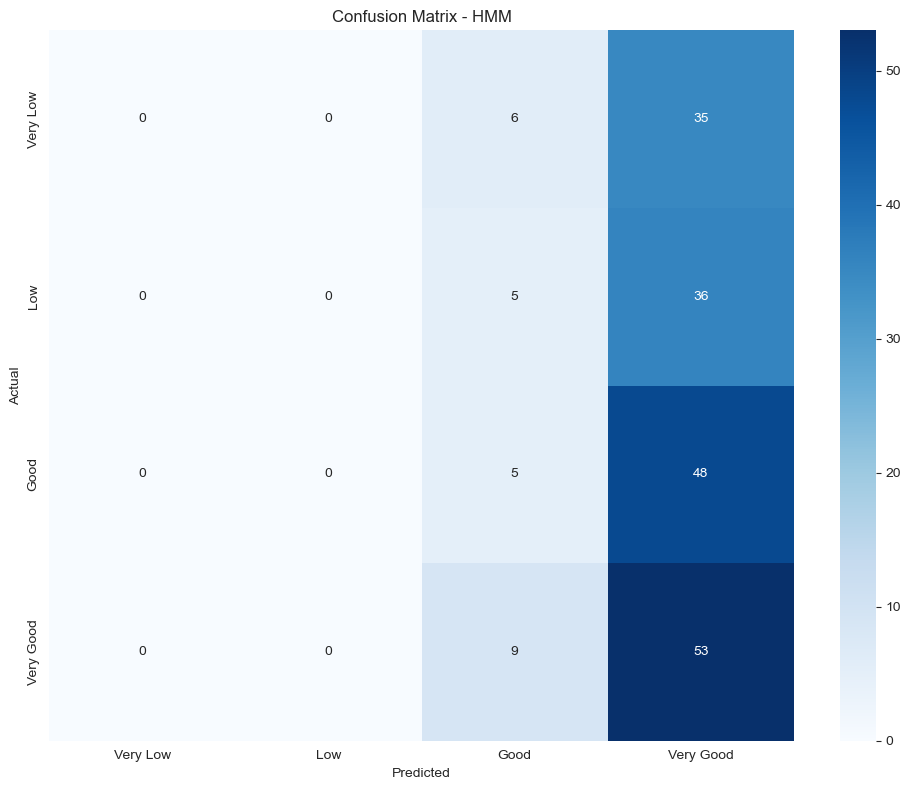

In [22]:
# Train Hidden Markov Model
try:
    hmm_results = train_hmm(X_train_window_scaled, y_train_window, X_test_window_scaled, y_test_window, 
                           user_ids_train_window, user_ids_test_window)
    results_window['HMM'] = hmm_results
except Exception as e:
    print(f"Error training HMM: {str(e)}")
    print("Skipping HMM model.")


Model Comparison:


,Model,accuracy,precision,recall,f1
0,Decision Tree,0.284264,0.277246,0.280840,0.278157
1,Random Forest,0.324873,0.281181,0.299315,0.283285
2,SVM,0.304569,0.274276,0.266663,0.236552
3,KNN,0.243655,0.233996,0.238256,0.234365
4,Logistic Regression,0.299492,0.291547,0.286045,0.280595
5,HMM,0.294416,0.127035,0.237295,0.145299


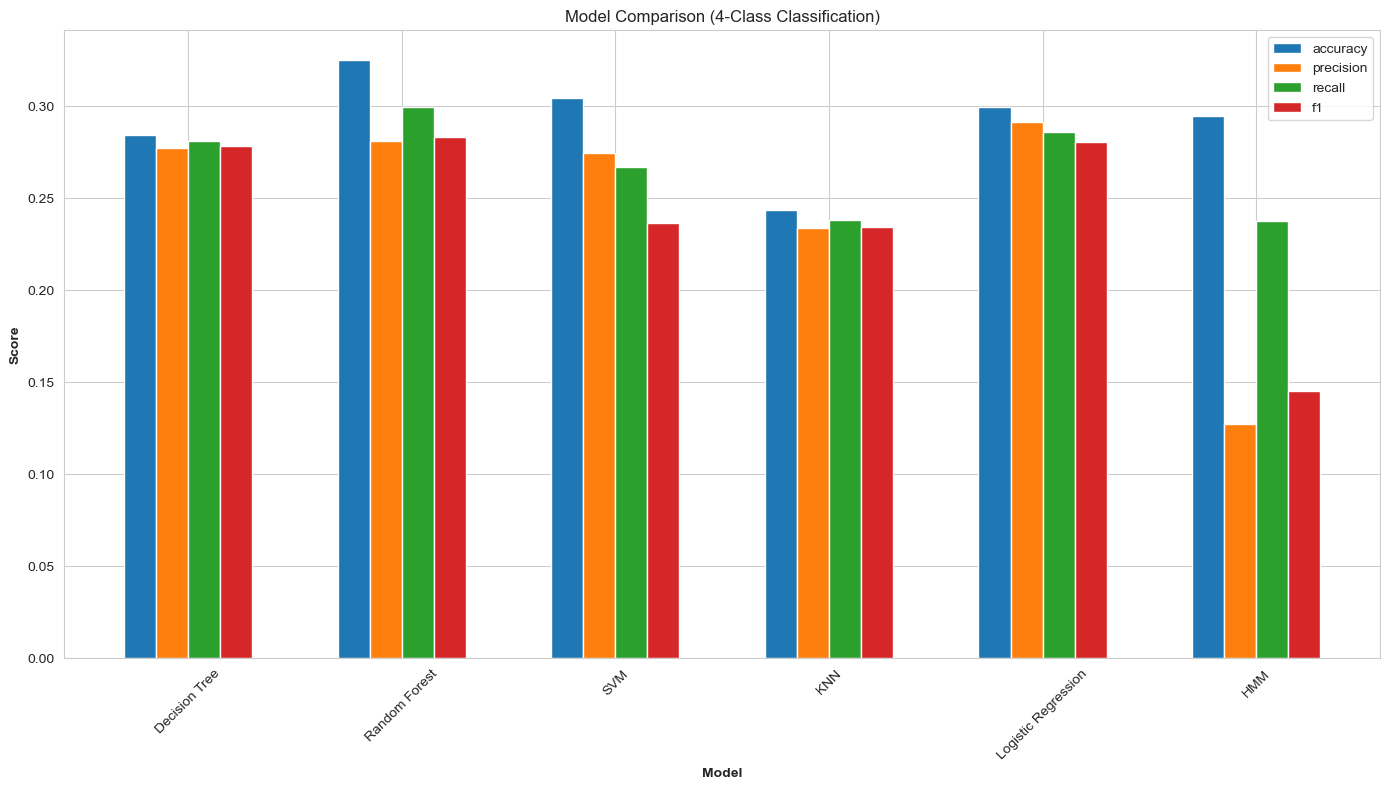


Best Model: Random Forest
F1 Score: 0.2833

Detailed Class Performance:

Decision Tree - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,14,6,11,10
True: Low,9,9,11,12
True: Good,14,12,11,16
True: Very Good,10,18,12,22



Random Forest - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,13,4,7,17
True: Low,8,2,9,22
True: Good,12,8,15,18
True: Very Good,6,5,17,34



SVM - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,6,2,9,24
True: Low,4,1,9,27
True: Good,6,2,15,30
True: Very Good,2,1,21,38



KNN - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,14,9,6,12
True: Low,10,4,9,18
True: Good,9,14,11,19
True: Very Good,16,12,15,19



Logistic Regression - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,14,4,9,14
True: Low,6,5,12,18
True: Good,13,5,13,22
True: Very Good,9,5,21,27



HMM - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,0,0,6,35
True: Low,0,0,5,36
True: Good,0,0,5,48
True: Very Good,0,0,9,53


In [23]:
def compare_models(results):
    # Create a DataFrame with model results
    model_names = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    comparison_data = []
    for name in model_names:
        row = [name]
        for metric in metrics:
            row.append(results[name][metric])
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data, columns=['Model'] + metrics)
    
    # Print comparison table
    print("\nModel Comparison:")
    display(comparison_df)
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    
    # Set width of bars
    barWidth = 0.15
    
    # Set positions of the bars on X axis
    r = np.arange(len(model_names))
    
    # Create bars
    for i, metric in enumerate(metrics):
        plt.bar(r + i * barWidth, comparison_df[metric], width=barWidth, label=metric)
    
    # Add labels and title
    plt.xlabel('Model', fontweight='bold')
    plt.ylabel('Score', fontweight='bold')
    plt.title('Model Comparison (4-Class Classification)')
    plt.xticks(r + barWidth * (len(metrics) - 1) / 2, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("./plots/model_comparison_4class.png")
    plt.show()
    
    # Find the best model based on F1 score
    best_model_idx = comparison_df['f1'].idxmax()
    best_model_name = comparison_df.loc[best_model_idx, 'Model']
    best_model = results[best_model_name]['model']
    
    print(f"\nBest Model: {best_model_name}")
    print(f"F1 Score: {results[best_model_name]['f1']:.4f}")
    
    # Create a more detailed comparison focusing on per-class performance
    print("\nDetailed Class Performance:")
    for name in model_names:
        print(f"\n{name} - Confusion Matrix:")
        display(pd.DataFrame(
            results[name]['confusion_matrix'],
            columns=['Pred: Very Low', 'Pred: Low', 'Pred: Good', 'Pred: Very Good'],
            index=['True: Very Low', 'True: Low', 'True: Good', 'True: Very Good']
        ))
    
    return best_model_name, best_model

# Compare models and find the best one
best_model_name, best_model = compare_models(results_window)

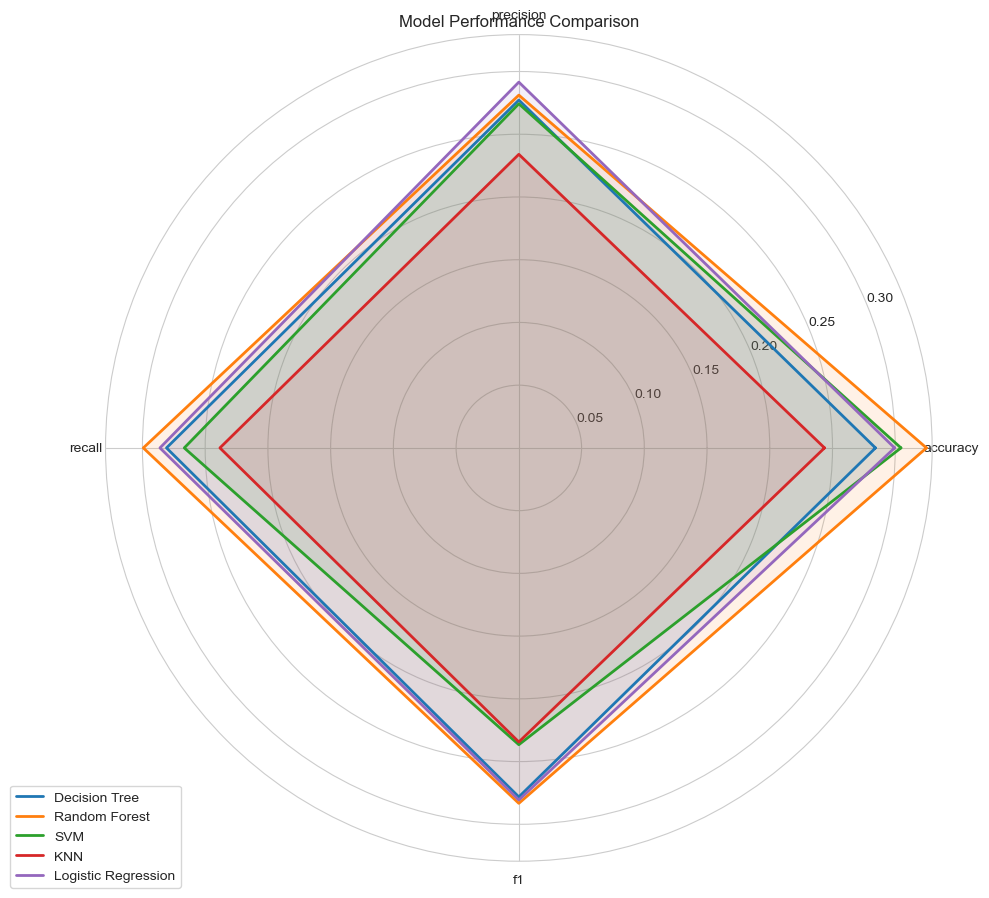

NameError: name 'y_test' is not defined

In [26]:
# Create a radar chart to visualize model performance across metrics
def radar_chart(results):
    """
    Create a radar chart to visualize model performance across metrics.
    """
    # Extract metrics
    model_names = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Create a DataFrame for the radar chart
    radar_data = []
    for name in model_names:
        row = [name]
        for metric in metrics:
            row.append(results[name][metric])
        radar_data.append(row)
    
    radar_df = pd.DataFrame(radar_data, columns=['Model'] + metrics)
    radar_df = radar_df.set_index('Model')
    
    # Create the radar chart
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Number of variables
    categories = metrics
    N = len(categories)
    
    # Create angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Plot each model
    for i, model in enumerate(radar_df.index):
        values = radar_df.loc[model].values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Set category labels
    plt.xticks(angles[:-1], categories)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title('Model Performance Comparison')
    plt.tight_layout()
    plt.savefig("./plots/radar_chart_4class.png")
    plt.show()

# Create radar chart
radar_chart(results)

# Visualize predictions for each class
def visualize_class_predictions(results, y_test):
    """
    Visualize how each model performs for each mood class.
    """
    # Create a DataFrame to store class-wise accuracy
    class_accuracy = pd.DataFrame(index=results.keys(), columns=['Very Low', 'Low', 'Good', 'Very Good'])
    
    for model_name, model_results in results.items():
        y_pred = model_results['y_pred']
        
        # Calculate accuracy for each class
        for class_idx in range(4):
            # Get indices where true label is this class
            class_indices = (y_test == class_idx)
            if np.any(class_indices):
                # Calculate accuracy for this class
                class_acc = accuracy_score(y_test[class_indices], y_pred[class_indices])
                class_accuracy.loc[model_name, ['Very Low', 'Low', 'Good', 'Very Good'][class_idx]] = class_acc
    
    # Plot class-wise accuracy
    plt.figure(figsize=(12, 8))
    class_accuracy.plot(kind='bar')
    plt.title('Class-wise Accuracy by Model')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend(title='Mood Class')
    plt.tight_layout()
    plt.savefig("./plots/class_accuracy_4class.png")
    plt.show()
    
    return class_accuracy

# Visualize class predictions
class_accuracy = visualize_class_predictions(results, y_test)
display(class_accuracy)

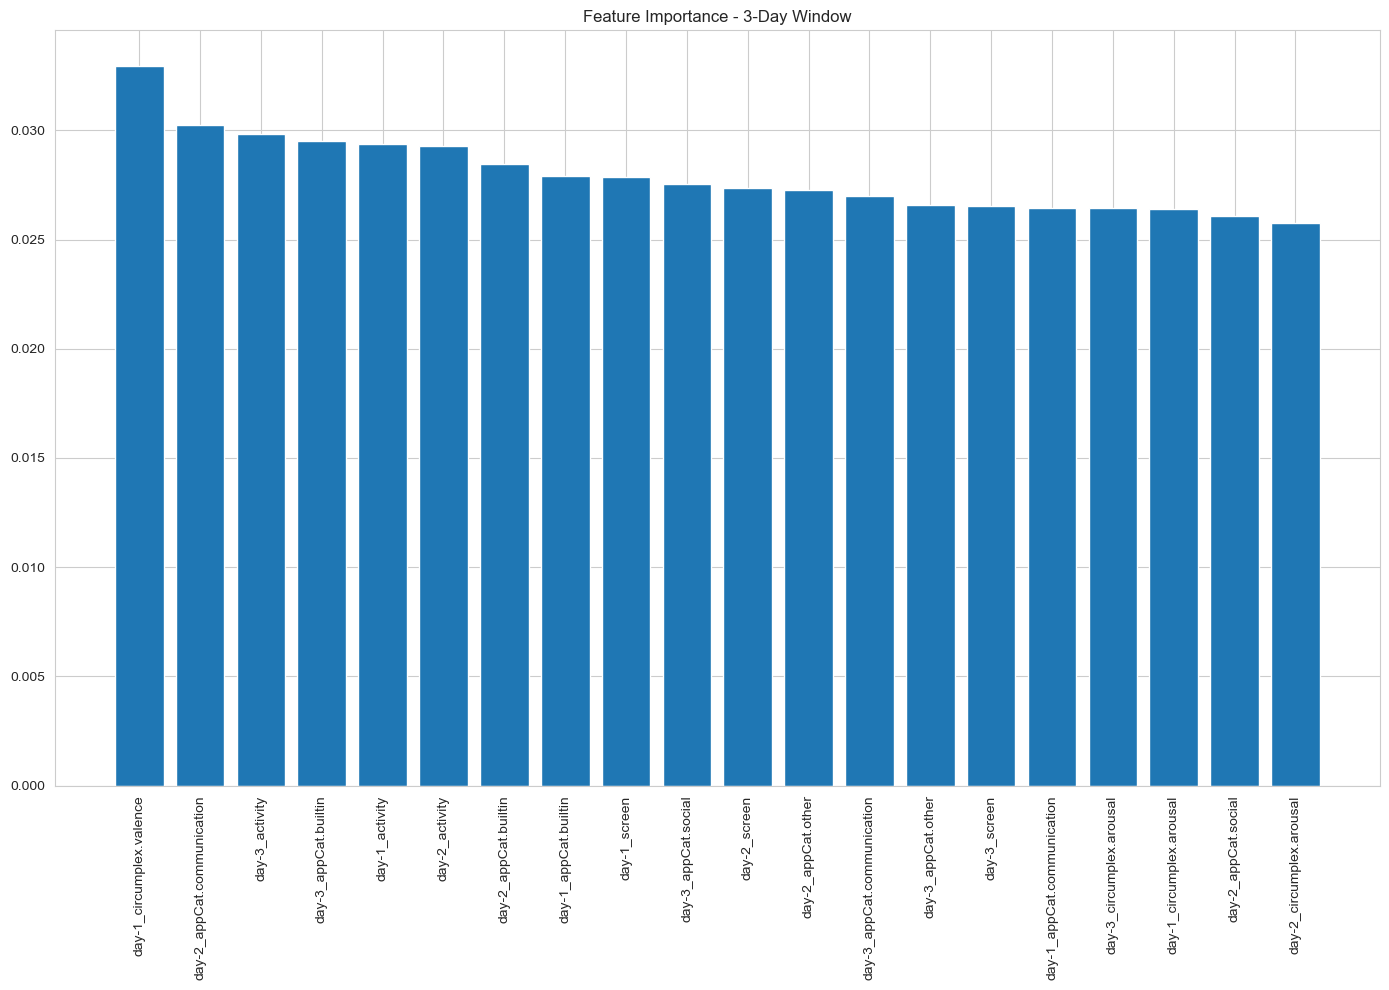


Top Features by Day (3-Day Window):
day-2: 0.3364
day-1: 0.3320
day-3: 0.3316


In [27]:
# Analyze feature importance for sliding window approach
if 'Random Forest' in results_window:
    rf_model = results_window['Random Forest']['model']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot top 20 features
    plt.figure(figsize=(14, 10))
    plt.title(f'Feature Importance - {window_size}-Day Window')
    plt.bar(range(20), importances[indices[:20]], align='center')
    plt.xticks(range(20), [feature_names_window[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.savefig(f"./plots/feature_importance_{window_size}day_window.png")
    plt.show()
    
    # Print top features by day
    print(f"\nTop Features by Day ({window_size}-Day Window):")
    day_importance = {}
    
    for i, feat in enumerate(feature_names_window):
        day = feat.split('_')[0]  # Extract day-N part
        if day not in day_importance:
            day_importance[day] = 0
        day_importance[day] += importances[i]
    
    # Sort days by importance
    sorted_days = sorted(day_importance.items(), key=lambda x: x[1], reverse=True)
    for day, importance in sorted_days:
        print(f"{day}: {importance:.4f}")


### Future Improvements (AI):

1. **Enhanced Temporal Models**: Implement more sophisticated temporal models like LSTM networks or Transformer-based models.

2. **Feature Engineering**: Create more temporal features such as trend indicators and cyclical patterns.

3. **Class Balancing**: Apply techniques to address class imbalance.

4. **Hyperparameter Tuning**: Conduct more extensive hyperparameter optimization.

5. **Ensemble Methods**: Combine multiple models to improve prediction accuracy.